# Ticket inspection AI

## Config

In [271]:
IS_WINDOWS = True
SAVE_AS_BEST = False
OLD_LINJE_TO_NEW = True

# Trials
TWO_TRIALS = 500
FOUR_TRIALS = 1_000

## Imports

In [272]:
import random
import pickle as pk

import matplotlib.pyplot as plt
import numpy as np
import optuna as opt
import pandas as pd
from sdv.evaluation import evaluate
from sdv.tabular import GaussianCopula
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

## Functions

In [273]:
def strCleaner(x: str):
    if isinstance(x, str):
        x = x.lower()
        x = x.replace(" ", "_")

        if "ja" in x:
            return "ja"

        return x
    else:
        return -1


def clockTofloat(x: str) -> float:
    x = x[:-3]
    x = x.replace(":",".")
    x = float(x)
    return x

def extractHour(x):
    return x.hour

def extractMinute(x):
    return x.minute

def findCatCode(l, x: str) -> int:
    for i in range(len(l)):
        if l[i] == x:
            code = l.codes[i]
            return code
        
def datetimeToInt(dt) -> int:
    # second = dt.second
    minute = dt.minute*1
    hour = dt.hour*10
    day = dt.day*10000
    month = dt.month*1000000
    year = dt.year*100000000
    
    ret = minute+hour+day+month+year
    return ret

def extractDay(dt):
    return dt.day
    
def extractMonth(dt):
    return dt.month

def extractYear(dt):
    return dt.year

def convert_linje_to_new(linje_inn):
    match linje_inn:
        case 'l14':
            return 'r14'
        case 'l12':
            return 'r12'
        case 'r11':
            return 're11'
        case 'r10':
            return 're10'
    return linje_inn

# Reading data

In [274]:
if IS_WINDOWS:
    db_main = pd.read_excel('C:/Users/sigzu/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data.xlsx')
    db_aanerud = pd.read_excel('C:/Users/sigzu/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data-aanerud.xlsx')
else:
    db_main = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data.xlsx")
    db_aanerud = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data-aanerud.xlsx")

db_aanerud.head(3)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,R14,Fremst,2023-01-21,16:54:00,Skarnes,Oslo s,Nei,Nei,NaN
1,R14,NaN,2023-01-22,17:04:00,Oslo s,Kongsvinger,Nei,Ja,Ble sjekket med en gang toget reiste
2,R14,4,2023-01-27,16:32:00,Oslo s,Årnes,Nei,Nei,NaN


In [275]:
db = pd.concat([db_main, db_aanerud])
db.tail(2)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
2,R14,4,2023-01-27,16:32:00,Oslo s,Årnes,Nei,Nei,NaN
3,R14,4,2023-02-10,12:04:00,Oslo s,Skarnes,Nei,Ja,"Ble sjekket på seterstøa, nettsiden sa det var..."


In [276]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 0 to 3
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Linje     82 non-null     object        
 1   Vogn      81 non-null     object        
 2   Dato      82 non-null     datetime64[ns]
 3   Klokke    82 non-null     object        
 4   Fra       82 non-null     object        
 5   Til       82 non-null     object        
 6   Fullt?    82 non-null     object        
 7   Sjekket?  82 non-null     object        
 8   Merknad   19 non-null     object        
dtypes: datetime64[ns](1), object(8)
memory usage: 6.4+ KB


# Data cleaning and engineering

## Categorize the features

In [277]:
db.fillna(-1)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,L12,Fremst,2022-09-25,11:30:00,Eidsvoll,Oslo Lufthavn,Nei,Nei,-1
1,R10,Bakerst,2022-09-25,21:59:00,Oslo Lufthavn,Eidsvoll,Ja,Ja,-1
2,L12,Fremst,2022-09-26,09:30:00,Eidsvoll,Nationaltheatret,Ja,Nei,-1
3,L12,Bakerst,2022-09-26,13:48:00,Nationaltheatret,Eidsvoll,Ja,Nei,-1
4,R11,Fremst,2022-09-27,06:00:00,Eidsvoll,Oslo Lufthavn,Nei,Ja,-1
...,...,...,...,...,...,...,...,...,...
77,R12,Bakerst,2023-02-09,14:48:00,Nationaltheatret,Eidsvoll,Ja,Nei,Pækkærn fullt
0,R14,Fremst,2023-01-21,16:54:00,Skarnes,Oslo s,Nei,Nei,-1
1,R14,-1,2023-01-22,17:04:00,Oslo s,Kongsvinger,Nei,Ja,Ble sjekket med en gang toget reiste
2,R14,4,2023-01-27,16:32:00,Oslo s,Årnes,Nei,Nei,-1


In [278]:
db["Fullt?"] = db["Fullt?"].apply(lambda x: strCleaner(x))
fulltCat = pd.Categorical(db["Fullt?"])
db["Fullt?"] = pd.Categorical(db["Fullt?"]).codes

db["Sjekket?"] = db["Sjekket?"].apply(lambda x: strCleaner(x))
sjekketCat = pd.Categorical(db["Sjekket?"])
db["Sjekket?"] = pd.Categorical(db["Sjekket?"]).codes

db["Fra"] = db["Fra"].apply(lambda x: strCleaner(x))
fraCat = pd.Categorical(db["Fra"])
db["Fra"] = pd.Categorical(db["Fra"]).codes

db["Til"] = db["Til"].apply(lambda x: strCleaner(x))
tilCat = pd.Categorical(db["Til"])
db["Til"] = pd.Categorical(db["Til"]).codes

In [279]:
db["Linje"] = db["Linje"].apply(lambda x: strCleaner(x))

# Converts old lines to new
if OLD_LINJE_TO_NEW:
    db["Linje"] = db["Linje"].apply(lambda x: convert_linje_to_new(x))

linjeCat = pd.Categorical(db["Linje"])
db["Linje"] = pd.Categorical(db["Linje"]).codes

Vogn needs to be converted to a string

In [280]:
db["Vogn"] = pd.Series(db["Vogn"], dtype="string")
db["Vogn"] = db["Vogn"].apply(lambda x: strCleaner(x))

vognCat = pd.Categorical(db["Vogn"])
db["Vogn"] = pd.Categorical(db["Vogn"]).codes

Merknad needs to convert all empty values to -1

In [281]:
db["Merknad"].fillna(-1)

merknadCat = pd.Categorical(db["Merknad"])
db["Merknad"] = pd.Categorical(db["Merknad"]).codes

### Check that categories are correct

In [282]:
print(linjeCat.categories)
print(fraCat.categories)
print(tilCat.categories)
print(fulltCat.categories)
print(sjekketCat.categories)

Index(['r12', 'r13', 'r14', 're10', 're11'], dtype='object')
Index(['eidsvoll', 'nationaltheatret', 'oslo_lufthavn', 'oslo_s', 'skarnes'], dtype='object')
Index(['eidsvoll', 'jessheim', 'kongsvinger', 'nationaltheatret',
       'oslo_lufthavn', 'oslo_s', 'skarnes', 'årnes'],
      dtype='object')
Index(['ja', 'nei', 'noe'], dtype='object')
Index(['ja', 'nei'], dtype='object')


Extract date sub-categories

In [283]:
# db['Dato'] = (db['Dato'] - db['Dato'].min())  / np.timedelta64(1,'D')
# db["Dato"] = db["Dato"].apply(lambda x: datetimeToInt(x))
# db["Dato"].head(3)

In [284]:
db["Dag"] = db["Dato"].apply(lambda x: extractDay(x))
db["Måned"] = db["Dato"].apply(lambda x: extractMonth(x))
# db["År"] = db["Dato"].apply(lambda x: extractYear(x)) # Not relevant for the timescale I have

db = db.drop("Dato", axis=1)
db.head(3)

,Linje,Vogn,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned
0,0,3,11:30:00,0,4,1,1,-1,25,9
1,3,2,21:59:00,2,0,0,0,-1,25,9
2,0,3,09:30:00,0,3,0,1,-1,26,9


Exctract time sub-categories

In [285]:
# db["Klokke"] = pd.Series(db["Klokke"], dtype="str")
# db["Klokke"] = db["Klokke"].apply(lambda x: clockTofloat(x))

In [286]:
db["Time"] = db["Klokke"].apply(lambda x: extractHour(x))
db["Minutt"] = db["Klokke"].apply(lambda x: extractMinute(x))

db = db.drop("Klokke", axis=1)
db.head(3)

,Linje,Vogn,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,0,3,0,4,1,1,-1,25,9,11,30
1,3,2,2,0,0,0,-1,25,9,21,59
2,0,3,0,3,0,1,-1,26,9,9,30


In [287]:
# Vogn is just noise
db = db.drop("Vogn", axis=1)

In [288]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 0 to 3
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Linje     82 non-null     int8 
 1   Fra       82 non-null     int8 
 2   Til       82 non-null     int8 
 3   Fullt?    82 non-null     int8 
 4   Sjekket?  82 non-null     int8 
 5   Merknad   82 non-null     int8 
 6   Dag       82 non-null     int64
 7   Måned     82 non-null     int64
 8   Time      82 non-null     int64
 9   Minutt    82 non-null     int64
dtypes: int64(4), int8(6)
memory usage: 3.7 KB


<AxesSubplot: >

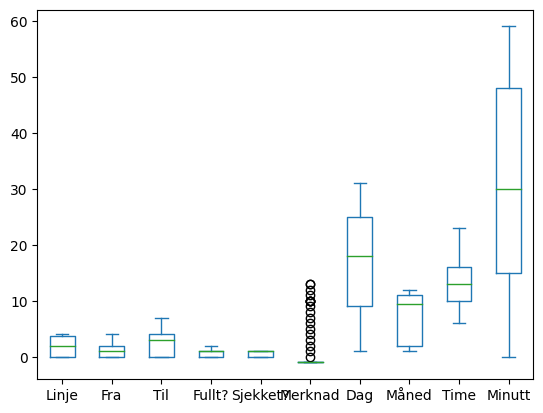

In [289]:
db.plot.box()

# Synthetic data

In [290]:
sdv = GaussianCopula()
sdv.fit(db)
sample = sdv.sample(1_000)
sample.head(3)

,Linje,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,2,0,4,0,1,4,30,6,12,37
1,3,0,4,1,1,3,8,12,7,30
2,2,1,2,1,1,7,2,11,9,33


In [291]:
# Dont work
#evaluate(sample, db, metrics=['CSTest'], aggregate=False)

In [292]:
db = pd.concat([db, sample])

# Creating testing data

In [293]:
# Create the data to create predict from
X = db.drop(["Sjekket?"], axis=1)

# Create the data to predict to
y = db["Sjekket?"]

# Merknad has gives no impact on result
X = X.drop(["Merknad"], axis=1)

### Testing without clock
# X = X.drop(["Klokke"], axis=1)

X.head(3)

,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,0,0,4,1,25,9,11,30
1,3,2,0,0,25,9,21,59
2,0,0,3,0,26,9,9,30


# Train_test_split

In [294]:
# Split the data into train and test sets with test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating model1 - XGBoostClassifier

In [295]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [296]:
preds = model.predict(X_test)

## Model 1 testing

### Model 1's confusion matrix

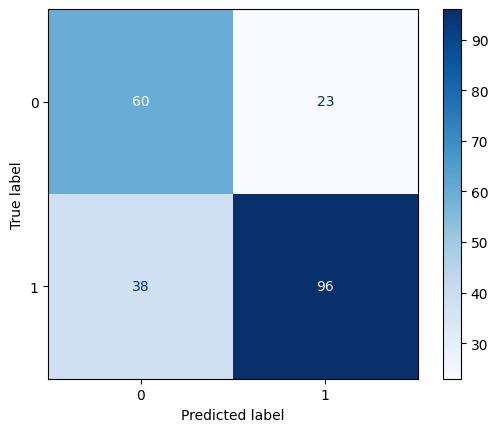

In [297]:
cm = confusion_matrix(y_true=y_test, y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

In [298]:
accuracy = accuracy_score(y_true=y_test, y_pred=preds)
print(f"Accuracy: {accuracy * 100.0 :.2f}")

Accuracy: 71.89


### Model 1's feature importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

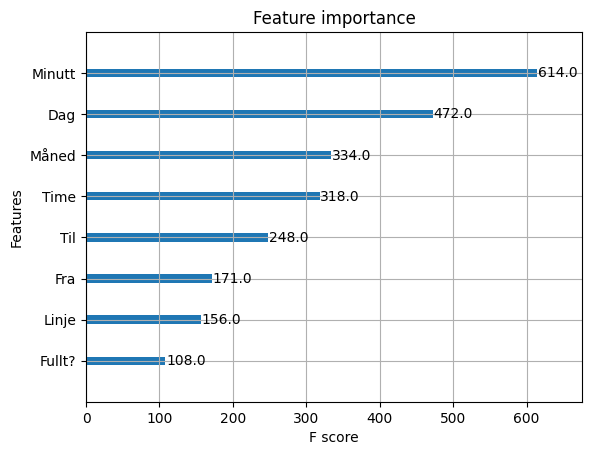

In [299]:
xgb.plot_importance(model)

# Creating model 2 - Model 1 with optuna

In [300]:
def objective(trial):
    """The objective is to find the best parameters for the most accuracy in the model"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1e+3),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=TWO_TRIALS)

[I 2023-02-10 18:24:11,362] A new study created in memory with name: no-name-eef3e7bc-34a9-4b9e-b264-297e18bf31a9
c:\Users\sigzu\miniconda3\envs\billettkontroll3.10\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2023-02-10 18:24:11,428] Trial 0 finished with value: 0.6175115207373272 and parameters: {'max_depth': 9, 'learning_rate': 0.12713073734208818, 'n_estimators': 163, 'min_child_weight': 1, 'gamma': 511.3192347375493, 'subsample': 0.18029000657793695, 'colsample_bytree': 0.16081447113417766, 'reg_alpha': 0.03775169240255297, 'reg_lambda': 0.5593779895054193}. Best is trial 0 with value: 0.6175115207373272.
c:\Users\sigzu\miniconda3\envs\billettkontroll3.10\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2023-02-10 18:24:11,515] Trial 1 finished wi

In [301]:
bparams = study.best_params
model2 = xgb.XGBClassifier(**bparams)
model2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.48639682229801245, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=15.714464631001054, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.7323462244789671, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=340, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [302]:
preds2 = model2.predict(X_test)

## Model 2 testing

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

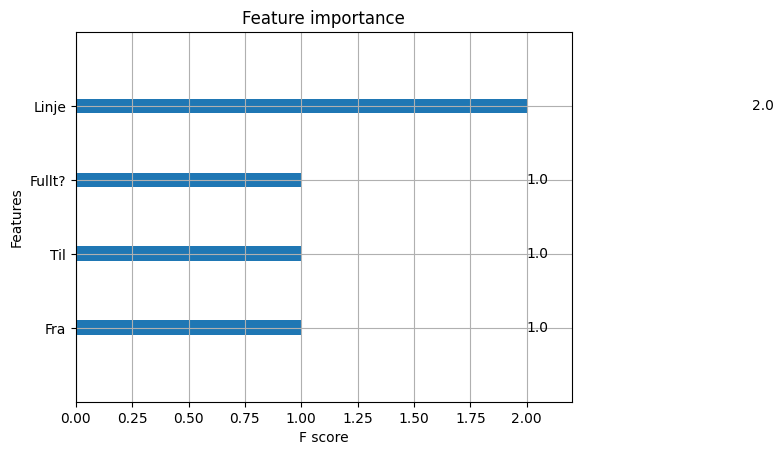

In [303]:
xgb.plot_importance(model2)

### Model 2 Confusion Matrix

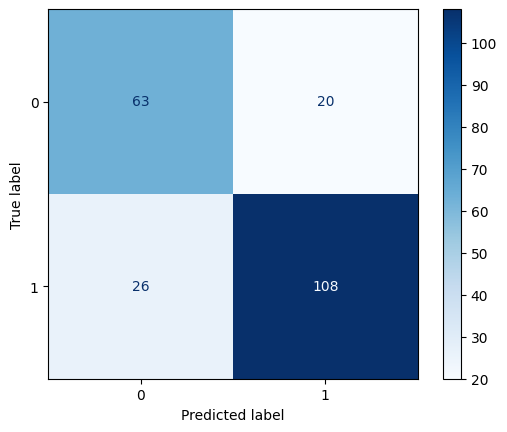

In [304]:
cm = confusion_matrix(y_true=y_test, y_pred=preds2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)

disp.plot(cmap='Blues')

In [305]:
accuracy2 = accuracy_score(y_true=y_test, y_pred=preds2)
print(f"Accuracy: {accuracy2 * 100.0 :.2f}")

Accuracy: 78.80


# Model 3 - Logistic regression

In [306]:
model3 = LogisticRegression(solver='liblinear', random_state=42)
model3.fit(X_train, y_train)
preds3 = model3.predict(X_test)


## Model 3 testing

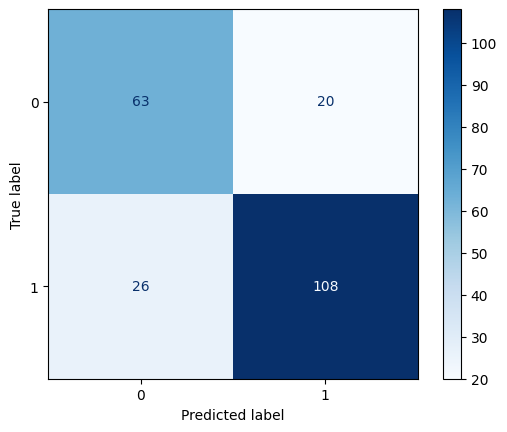

In [307]:
cm = confusion_matrix(y_true=y_test, y_pred=preds3)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)

disp.plot(cmap='Blues')

In [308]:
print(model3.score(X_test, y_test))
accuracy3 = accuracy_score(y_true=y_test, y_pred=preds3)
print(f"Accuracy: {accuracy3 * 100.0 :.2f}")

0.7327188940092166
Accuracy: 73.27


In [309]:
print(classification_report(y_test, preds3))

              precision    recall  f1-score   support

           0       0.63      0.75      0.68        83
           1       0.82      0.72      0.77       134

    accuracy                           0.73       217
   macro avg       0.72      0.74      0.73       217
weighted avg       0.75      0.73      0.74       217



# Model 4 - Logistic regression with optuna

In [310]:
heyho = {'hello': 'hi'}

if 'hello' in heyho:
    index = list(heyho.values())[0]

print(index)

hi


In [311]:
def check_value_exist(dict: dict, liste: list) -> bool:
    do_exist = False
    for l in liste:
            for key, val in dict.items():
                if val == l:
                    do_exist = True
    return do_exist

In [312]:
def objective(trial):
    """
    Tests parameters for sciKit LogicalRegression
    """


    # Cant use suggest_categorical for multiple strings. Crashes
    # Tried with setting string values from random list number, dont work
    # CANT ACTUALLY SET STRING VALUES WIHTOUT USING CATEGORICAL, and that not workign with multiple
    # Solver
    # solver_num = random.randint(0, 4)
    # solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    solver = 'liblinear' # solver_list[solver_num]
    # fit_intercept
    # fit_num = trial.suggest_int('fit_num', 0, 1)

    params = {
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'C': trial.suggest_float('C', 0.0, 1.0),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'random_state': trial.suggest_int('random_state', 0, 50),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0, 1.0),
        'solver': trial.suggest_categorical('solver', [solver]),
        'max_iter': trial.suggest_int('max_iter', 0, 60)
    }

    # Pentalty
    #if check_value_exist(params, ['newton-cg', 'lbfgs', 'sag']):
    #    number = random.randint(0, 1)
    #    if number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])})
    #elif check_value_exist(params, ['liblinear']):
    #number = random.randint(0, 1)
    #if number == 1:
    params.update({'penalty': trial.suggest_categorical('penalty', ["l1", "l2"])}) # l1 sucks with liblinear, dont use
    #else:
    #    params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #elif check_value_exist(params, ['saga']):
    #    number = random.randint(0, 3)
    #    if number == 0:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["elasticnet"])})
    #    elif number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    elif number == 2:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l1"])})  
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])}) 

    # l1_ratio //sucks balls man
    if check_value_exist(params, ['l1', 'elasticnet']):
        params.update({'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0)})

    # Dual
    if check_value_exist(params, ['l2']) and check_value_exist(params, ['liblinear']):
        params.update({'dual': trial.suggest_categorical('dual', [True, False])})
    #else:
    #    params.update({'dual': trial.suggest_categorical('dual', [False])})

    # Fit the model
    optuna_model = LogisticRegression(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=FOUR_TRIALS)

[I 2023-02-10 18:25:30,739] A new study created in memory with name: no-name-495268ea-c0ca-477b-8d30-c036f1580402
c:\Users\sigzu\miniconda3\envs\billettkontroll3.10\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
[I 2023-02-10 18:25:30,748] Trial 0 finished with value: 0.7373271889400922 and parameters: {'tol': 0.04157068775297186, 'C': 0.25666704884694147, 'fit_intercept': False, 'random_state': 5, 'intercept_scaling': 0.8535157824309558, 'solver': 'liblinear', 'max_iter': 12, 'penalty': 'l1', 'l1_ratio': 0.6501614228393491}. Best is trial 0 with value: 0.7373271889400922.
[I 2023-02-10 18:25:30,753] Trial 1 finished with value: 0.7373271889400922 and parameters: {'tol': 0.06837313883728749, 'C': 0.15401148650871943, 'fit_intercept': True, 'random_state': 48, 'intercept_scaling': 0.811158478991512, 'solver': 'liblinear', 'max_iter': 23, 'penalty': 'l2', 'dual': False}

In [313]:
bparams = study.best_params
model4 = LogisticRegression(**bparams)
model4.fit(X_train, y_train)
preds4 = model4.predict(X_test)
bparams

c:\Users\sigzu\miniconda3\envs\billettkontroll3.10\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'tol': 0.05774692083100901,
 'C': 0.18070500133880493,
 'fit_intercept': True,
 'random_state': 1,
 'intercept_scaling': 0.4736557562883218,
 'solver': 'liblinear',
 'max_iter': 40,
 'penalty': 'l2',
 'dual': True}

## Model 4 testing

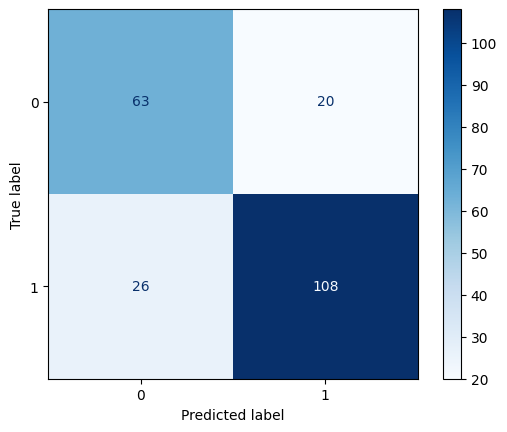

In [314]:
cm = confusion_matrix(y_true=y_test, y_pred=preds4)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)

disp.plot(cmap='Blues')

In [315]:
print(model4.score(X_test, y_test))
accuracy4 = accuracy_score(y_true=y_test, y_pred=preds4)
print(f"Accuracy: {accuracy4 * 100.0 :.2f}")

0.7972350230414746
Accuracy: 79.72


# Best

In [316]:
accuracies = [accuracy, accuracy2, accuracy3, accuracy4]

counter = 1
best_a = 0
for a in accuracies:
    if a > best_a:
        best = counter
        best_a = a
    
    counter = counter+1

print(f"Best is model number {best} with the score: {best_a * 100 :.2f}")

Best is model number 4 with the score: 79.72


In [317]:
if best == 1:
    bmodel = model
elif best == 2:
    bmodel = model2
elif best == 3:
    bmodel = model3
else:
    bmodel = model4

try:
    bmodel.save_model("../models/model.h5")
except:
    print("Can't save to H5 format.")

pk.dump(bmodel, open('../models/model.pkl', 'wb'))
pk.dump(best_a, open('../accuracy/accuracy.pkl', 'wb'))

Can't save to H5 format.


If this runs best model is better than altime best model, replace with this

In [318]:
if SAVE_AS_BEST:
    pk.dump(bmodel, open('../models/best_model.pkl', 'wb'))
    pk.dump(best_a, open('../accuracy/best_accuracy.pkl', 'wb'))

    print(f"This rounds best model with {best_a * 100 :.2f}% was saved as alltime best due to config.")
else:
    best_best_a = pk.load(open('../accuracy/best_accuracy.pkl', 'rb'))

    if best_a > best_best_a:
        pk.dump(bmodel, open('../models/best_model.pkl', 'wb'))
        pk.dump(best_a, open('../accuracy/best_accuracy.pkl', 'wb'))
        best_best_a = best_a

    print(f"Best: {best_a} Best_best: {best_best_a}")

Best: 0.7972350230414746 Best_best: 0.7972350230414746


In [319]:
pk.dump(X_test, open('../categories/X_test.pkl', 'wb'))

In [320]:
if SAVE_AS_BEST or best_a > best_best_a:
    pk.dump(linjeCat, open('../categories/linjeCat.pkl', 'wb'))
    pk.dump(vognCat, open('../categories/vognCat.pkl', 'wb'))
    pk.dump(fraCat, open('../categories/fraCat.pkl', 'wb'))
    pk.dump(tilCat, open('../categories/tilCat.pkl', 'wb'))
    pk.dump(fulltCat, open('../categories/fulltCat.pkl', 'wb'))
    pk.dump(sjekketCat, open('../categories/sjekketCat.pkl', 'wb'))

# Self testing

In [321]:
X_test.head(5)

,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
56,2,4,5,1,18,1,12,52
369,4,0,4,0,16,10,11,26
506,3,1,5,2,15,7,9,19
622,3,1,2,2,15,8,8,9
51,3,2,0,0,15,12,18,59


In [322]:
y_test.head(5)

56     1
369    0
506    0
622    0
51     0
Name: Sjekket?, dtype: int8

In [323]:
tester = X_test
tester = tester.drop(X_test.index)
tester

# Parameters
linje = "re11"
#vogn = "fremst"
fra = "nationaltheatret"
til = "eidsvoll"
fullt = "ja"
dag = 31
måned = 10
time = 14
minutt = 35

data = {"Linje": [findCatCode(linjeCat, linje)], 
          #"Vogn": [findCatCode(vognCat, vogn)],
          "Fra": [findCatCode(fraCat, fra)], 
          "Til": [findCatCode(tilCat, til)], 
         "Fullt?": [findCatCode(fulltCat, fullt)],
         "Dag": [dag],
         "Måned": [måned],
         "Time": [time],
         "Minutt": [minutt]}

testdb = pd.DataFrame(data)

tester = pd.concat([tester, testdb])
tester


,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,4,1,0,0,31,10,14,35


In [324]:
# Finds what the number means
ja = findCatCode(sjekketCat, 'ja')
nei = findCatCode(sjekketCat, 'nei')

print(f"{nei} = Nei\n"+
      f"{ja} = Ja")

testpred = bmodel.predict(tester)
print(f"Predicted: {testpred}")

if testpred[0] == ja:
    print("Ja, det er en sannsynlighet for å bli kontrollert")
else:
    print("Nei, det er liten sannsynlighet for å bli kontrollert")

1 = Nei
0 = Ja
Predicted: [1]
Nei, det er liten sannsynlighet for å bli kontrollert


In [325]:
linjer = list(linjeCat.categories)
linjer

['r12', 'r13', 'r14', 're10', 're11']